## Penguin 6 types classification model (ImageNet VGG16  based)

In [1]:
from keras import layers
from keras import models


Using TensorFlow backend.


In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

base_dir = '/notebooks/penguins_128'
train_dir = os.path.join(base_dir, 'train')
input_shape=(128, 128, 3)
num_classes=6
batch_size=10
validation_split=0.2

class PenguinsDataset():
    def __init__(self, train_dir, batch_size, target_size, validation_split):
        self.train_dir = train_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.validation_split = validation_split

    
    def create_generator(self, IDG_options={}):
        default_IDG_options = {'rescale':1./255, 'validation_split':self.validation_split}
        IDG_options.update(default_IDG_options)
        self.train_datagen = ImageDataGenerator(**IDG_options)
        self.plain_datagen = ImageDataGenerator(**default_IDG_options)        
        self.train_gen = self.train_datagen.flow_from_directory(
                self.train_dir,
                target_size=self.target_size,
                batch_size=self.batch_size,
                class_mode='categorical',
                subset='training')
        if self.validation_split > 0:
            self.valid_gen = self.plain_datagen.flow_from_directory(
                    self.train_dir,               
                    target_size=self.target_size,
                    batch_size=self.batch_size,  
                    class_mode='categorical',
                    subset='validation')
        
        image_suffix = ['.jpg', '.JPG']
        self.train_files = [x for x in Path(train_dir).glob('*/*') if x.suffix in image_suffix]
        
    def train_steps_per_epoch(self):
        return int(len(self.train_files) * (1 - self.validation_split) // self.batch_size)
    
    def validation_steps_per_epoch(self):
        return int(len(self.train_files) * (self.validation_split) // self.batch_size)



In [3]:
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint

#  Trainer class
class Trainer():

    def __init__(self, model, loss, optimizer, log_dir, model_file_name):
        self._target = model
        self._target.compile(
            loss=loss, optimizer=optimizer, metrics=["acc"]
            )
        self.verbose = 1
        self.log_dir = log_dir
        self.model_file_name = model_file_name

    def train(self,ds, batch_size, epochs):
        if os.path.exists(self.log_dir):
            import shutil
            shutil.rmtree(self.log_dir)  # remove previous execution
        os.mkdir(self.log_dir)

        model_path = os.path.join(self.log_dir, self.model_file_name)
        callbacks = [
            TensorBoard(log_dir=self.log_dir),
            ModelCheckpoint(model_path, 
                    monitor='val_loss', verbose=1, save_best_only=True),
        ]
        self.history = self._target.fit_generator(ds.train_gen, 
                                   steps_per_epoch=ds.train_steps_per_epoch(),
                                   epochs=epochs,
                                   validation_data=ds.valid_gen,
                                   validation_steps=ds.validation_steps_per_epoch(),
                                   callbacks=callbacks,
                                    verbose=self.verbose)


In [4]:
import numpy as np

# for test datasets
class Tester:
    def __init__(self, test_dir, target_size):
        files_num = len([x for x in Path(test_dir).glob('*/*') if x.suffix in ['.jpg', '.JPG']])
        test_ds = PenguinsDataset(test_dir, files_num, target_size, 0)
        test_ds.create_generator({})
        self.test_generator = test_ds.train_gen
        self.x_test, self.y_test = next(self.test_generator)
        self.y_list=np.argmax(self.y_test, axis=1)
    
    def predict(self, model):
        self.preds = model.predict(self.x_test)
        results_list=np.argmax(self.preds, axis=1)
        self.correct_no_list = [i for i in range(len(self.y_list)) if self.y_list[i] == results_list[i]]
        self.in_correct_no_list = [i for i in range(len(self.y_list)) if self.y_list[i] != results_list[i]]


In [5]:
# grad-cam
import cv2
from keras import backend as K

labels=['adelie', 'chinstrap', 'emperor', 'gentoo', 'king', 'rockhopper']

def imshow_friendly(img):
    img_temp = img - np.min(img)
    img_temp = img_temp/np.max(img_temp)
    friendly = np.uint8(255 * img_temp)
    return friendly

def visualize_cam(model, test_file_index, layer_name, tester):
    last_conv_layer = model.get_layer(layer_name)
    x = np.array([tester.x_test[test_file_index]])
    targ_class = np.argmax(tester.preds[test_file_index])
    
    output = model.output[:, targ_class]
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(int(last_conv_layer.output.shape[3])):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    img = tester.x_test[test_file_index]
    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax = fig.add_subplot(131)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    ax.set_axis_off()
    ax.matshow(heatmap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = ((heatmap*0.5/np.max(heatmap) + img)) / 1.5
    ax = fig.add_subplot(132)
    ax.set_axis_off()
    ax.imshow(imshow_friendly(superimposed))
    ax.set_title('%s? %s' % (labels[targ_class], 'yes' if test_file_index in tester.correct_no_list else 'no'), fontsize=12)
    ax = fig.add_subplot(133)
    ax.set_axis_off()
    ax.imshow(imshow_friendly(img)) 
    


## VGG16 imagenet based fine tuning (without Augmentation)

VGG16のImageNet学習済みモデルをベースに、全結合層をつけたネットワークを作成。

In [6]:
from keras.applications import VGG16

def imagenet_based_network(input_shape, num_classes):
    conv_base = VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=input_shape)
    x = conv_base.output
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=conv_base.input, outputs=predictions)
    return model, conv_base

    

はじめはベースネットワークを凍結して、追加した層のみを訓練します。凍結前と後で学習する重みが変化していることを確認。

In [7]:
ib_model, conv_base = imagenet_based_network(input_shape, num_classes)
print(len(ib_model.trainable_weights))

for layer in conv_base.layers:
    layer.trainable = False

print(len(ib_model.trainable_weights))

30
4


In [8]:
ib_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [9]:
# without Augmentation
ds = PenguinsDataset(train_dir, batch_size, input_shape[:2], validation_split)
ds.create_generator({})

trainer = Trainer(ib_model, loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=2e-5), 
                  log_dir="imagenet_no_aug", model_file_name="imagenet_no_aug.h5")
trainer.train(ds, batch_size=batch_size, epochs=30)


Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Epoch 1/30
240/240 [==============================] - 7s 28ms/step - loss: 1.6127 - acc: 0.3404 - val_loss: 1.4688 - val_acc: 0.4283

Epoch 00001: val_loss improved from inf to 1.46877, saving model to imagenet_no_aug/imagenet_no_aug.h5
Epoch 2/30
240/240 [==============================] - 5s 21ms/step - loss: 1.3320 - acc: 0.5146 - val_loss: 1.3039 - val_acc: 0.5250

Epoch 00002: val_loss improved from 1.46877 to 1.30395, saving model to imagenet_no_aug/imagenet_no_aug.h5
Epoch 3/30
240/240 [==============================] - 5s 21ms/step - loss: 1.1542 - acc: 0.5863 - val_loss: 1.1900 - val_acc: 0.5600

Epoch 00003: val_loss improved from 1.30395 to 1.19001, saving model to imagenet_no_aug/imagenet_no_aug.h5
Epoch 4/30
240/240 [==============================] - 5s 21ms/step - loss: 1.0233 - acc: 0.6638 - val_loss: 1.1148 - val_acc: 0.6133

Epoch 00004: val_loss improved from 1.19001 to 1.11481, saving m

次に、ベースネットワークの一部の層（最後の畳込みブロック5）を解凍して訓練させます。

In [10]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(len(ib_model.trainable_weights))

10


In [11]:
model_path = os.path.join(trainer.log_dir, trainer.model_file_name)
callbacks = [
    TensorBoard(log_dir=trainer.log_dir),
    ModelCheckpoint(model_path, 
        monitor='val_loss', verbose=1, save_best_only=True),
]
ib_model.compile(loss="categorical_crossentropy", 
                 optimizer=optimizers.RMSprop(lr=1e-5), 
                 metrics=["acc"])
history = ib_model.fit_generator(ds.train_gen, 
    steps_per_epoch=ds.train_steps_per_epoch(),
    epochs=100,
    validation_data=ds.valid_gen,
    validation_steps=ds.validation_steps_per_epoch(),
    callbacks=callbacks,
    verbose=trainer.verbose)


Epoch 1/100
240/240 [==============================] - 8s 32ms/step - loss: 0.1663 - acc: 0.9583 - val_loss: 0.7666 - val_acc: 0.7467

Epoch 00001: val_loss improved from inf to 0.76660, saving model to imagenet_no_aug/imagenet_no_aug.h5
Epoch 2/100
240/240 [==============================] - 8s 31ms/step - loss: 0.0794 - acc: 0.9829 - val_loss: 0.8047 - val_acc: 0.7383

Epoch 00002: val_loss did not improve from 0.76660
Epoch 3/100
240/240 [==============================] - 8s 31ms/step - loss: 0.0420 - acc: 0.9937 - val_loss: 0.8196 - val_acc: 0.7517

Epoch 00003: val_loss did not improve from 0.76660
Epoch 4/100
240/240 [==============================] - 8s 32ms/step - loss: 0.0237 - acc: 0.9962 - val_loss: 0.8226 - val_acc: 0.7583

Epoch 00004: val_loss did not improve from 0.76660
Epoch 5/100
240/240 [==============================] - 8s 31ms/step - loss: 0.0137 - acc: 0.9983 - val_loss: 1.0153 - val_acc: 0.7567

Epoch 00005: val_loss did not improve from 0.76660
Epoch 6/100
240/24


Epoch 00044: val_loss did not improve from 0.76660
Epoch 45/100
240/240 [==============================] - 8s 31ms/step - loss: 0.0060 - acc: 0.9983 - val_loss: 1.2589 - val_acc: 0.8100

Epoch 00045: val_loss did not improve from 0.76660
Epoch 46/100
240/240 [==============================] - 8s 32ms/step - loss: 0.0061 - acc: 0.9987 - val_loss: 1.2456 - val_acc: 0.8133

Epoch 00046: val_loss did not improve from 0.76660
Epoch 47/100
240/240 [==============================] - 8s 31ms/step - loss: 0.0053 - acc: 0.9992 - val_loss: 1.2408 - val_acc: 0.8100

Epoch 00047: val_loss did not improve from 0.76660
Epoch 48/100
240/240 [==============================] - 8s 32ms/step - loss: 0.0049 - acc: 0.9987 - val_loss: 1.2554 - val_acc: 0.8083

Epoch 00048: val_loss did not improve from 0.76660
Epoch 49/100
240/240 [==============================] - 8s 32ms/step - loss: 0.0053 - acc: 0.9992 - val_loss: 1.2399 - val_acc: 0.8083

Epoch 00049: val_loss did not improve from 0.76660
Epoch 50/100



Epoch 00088: val_loss did not improve from 0.76660
Epoch 89/100
240/240 [==============================] - 8s 32ms/step - loss: 0.0020 - acc: 0.9987 - val_loss: 1.4720 - val_acc: 0.8083

Epoch 00089: val_loss did not improve from 0.76660
Epoch 90/100
240/240 [==============================] - 8s 32ms/step - loss: 0.0026 - acc: 0.9992 - val_loss: 1.4579 - val_acc: 0.8033

Epoch 00090: val_loss did not improve from 0.76660
Epoch 91/100
240/240 [==============================] - 8s 32ms/step - loss: 0.0019 - acc: 0.9992 - val_loss: 1.4670 - val_acc: 0.8017

Epoch 00091: val_loss did not improve from 0.76660
Epoch 92/100
240/240 [==============================] - 8s 31ms/step - loss: 0.0022 - acc: 0.9987 - val_loss: 1.4763 - val_acc: 0.7983

Epoch 00092: val_loss did not improve from 0.76660
Epoch 93/100
240/240 [==============================] - 8s 31ms/step - loss: 0.0022 - acc: 0.9987 - val_loss: 1.5317 - val_acc: 0.7983

Epoch 00093: val_loss did not improve from 0.76660
Epoch 94/100


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_graph(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # 正解率をプロット
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # 損失値をプロット
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

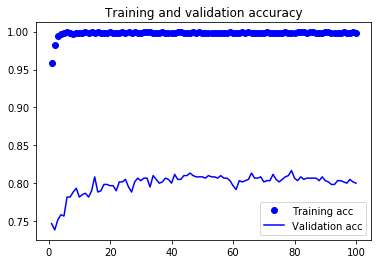

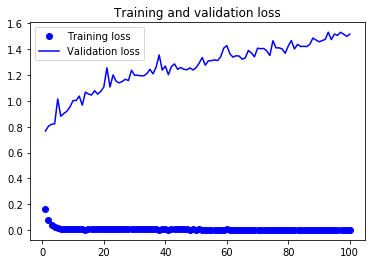

In [14]:
show_graph(history)

In [15]:
tester = Tester(os.path.join(base_dir, 'test'), input_shape[:2] )
tester.predict(ib_model)

score = ib_model.evaluate(tester.x_test, tester.y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 360 images belonging to 6 classes.
Test loss: 1.2935656685640828
Test accuracy: 0.8222222222222222


4層データ拡張ありよりも正解率が低いです。

In [16]:
output_tester = Tester(os.path.join(base_dir, 'for_output'), input_shape[:2] )
output_tester.predict(ib_model)
print(output_tester.correct_no_list)
print(output_tester.in_correct_no_list)

Found 42 images belonging to 6 classes.
[0, 1, 2, 3, 5, 8, 9, 10, 14, 15, 16, 19, 20, 21, 22, 24, 25, 28, 31, 34, 35, 36, 37, 39, 40, 41]
[4, 6, 7, 11, 12, 13, 17, 18, 23, 26, 27, 29, 30, 32, 33, 38]


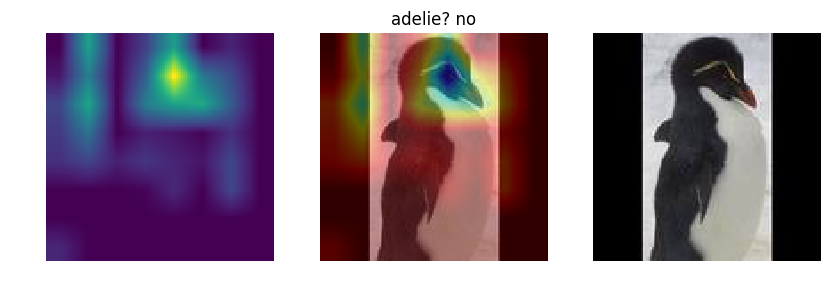

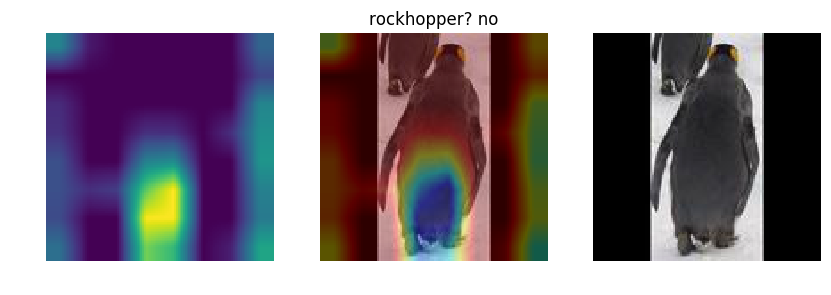

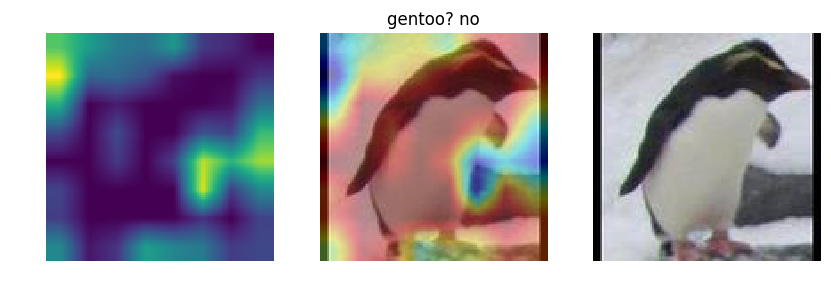

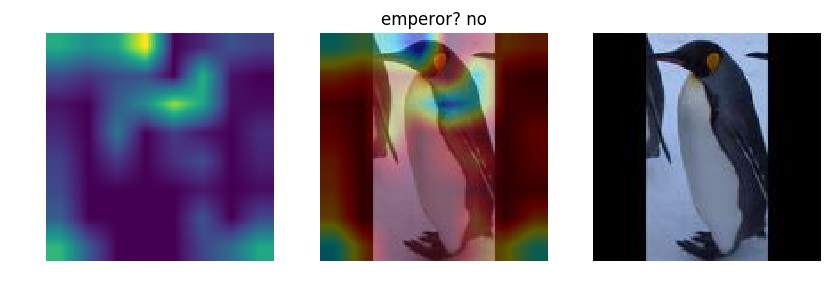

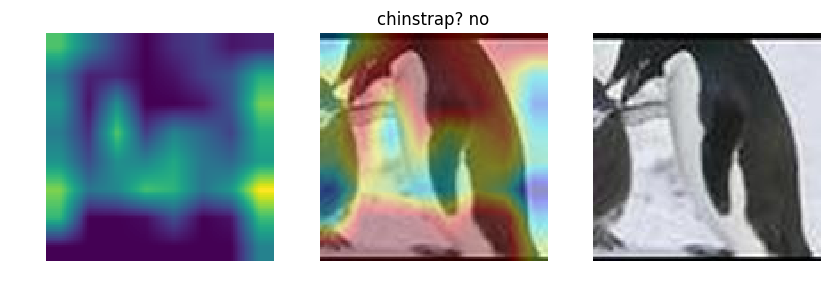

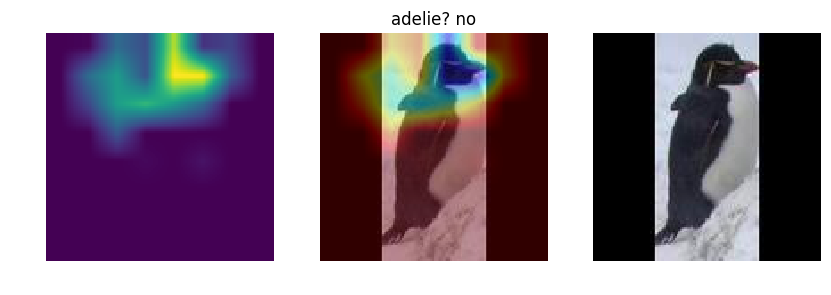

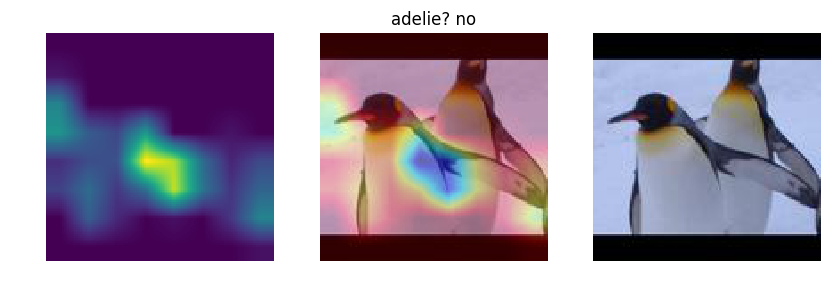

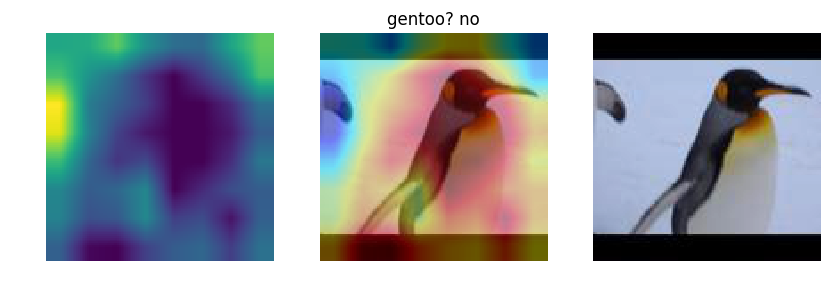

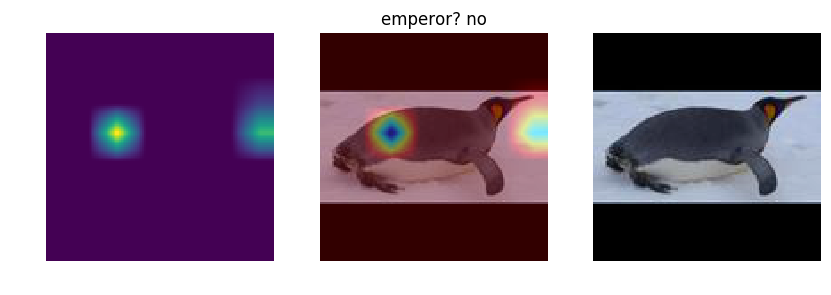

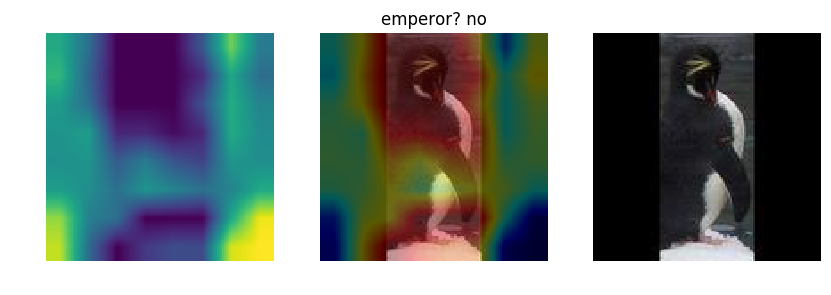

In [17]:
# 5番目の畳込みブロック
for i in range(10):
    visualize_cam(ib_model, output_tester.in_correct_no_list[i], 'block5_conv1', output_tester)
plt.show()

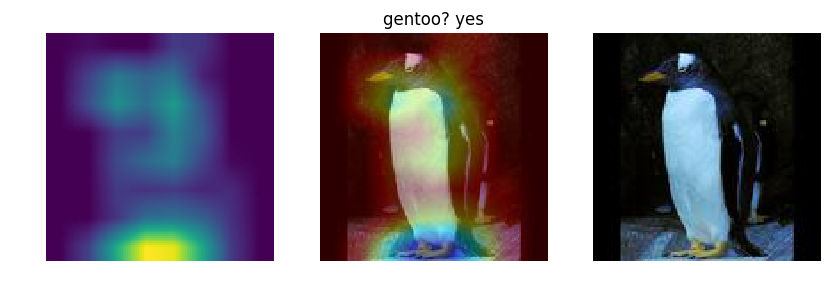

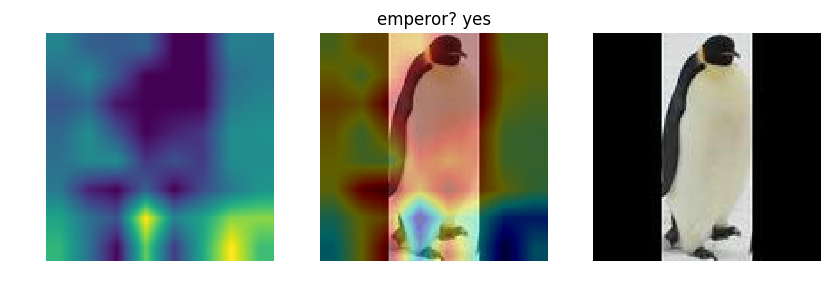

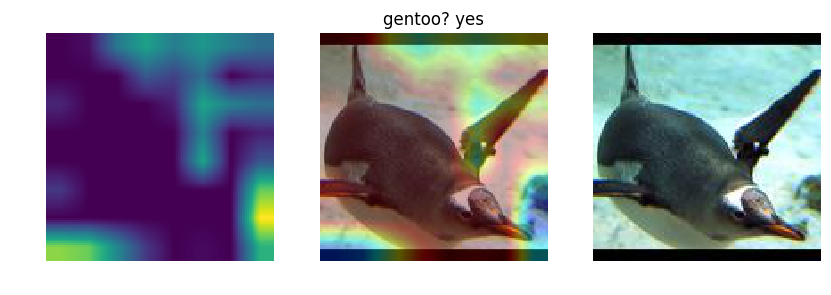

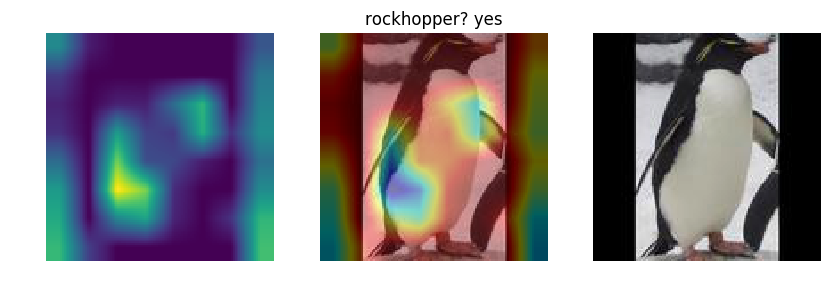

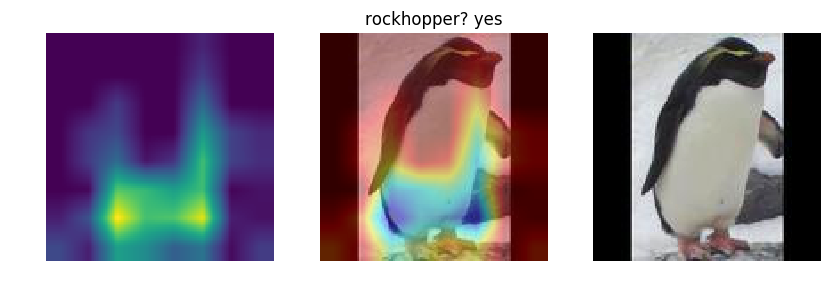

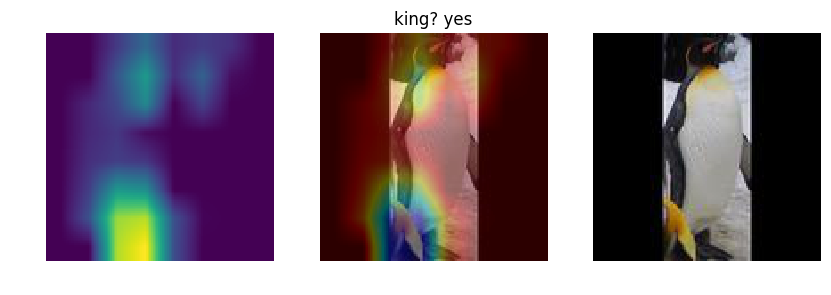

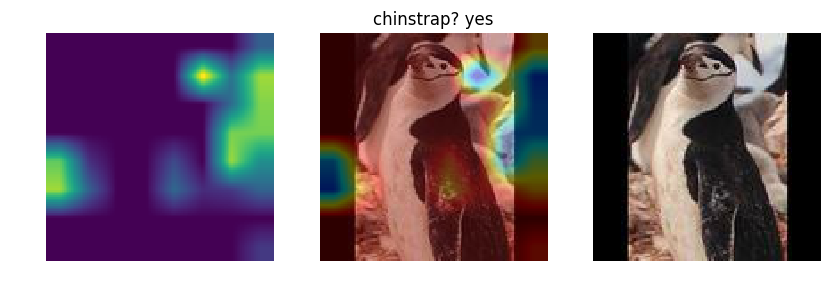

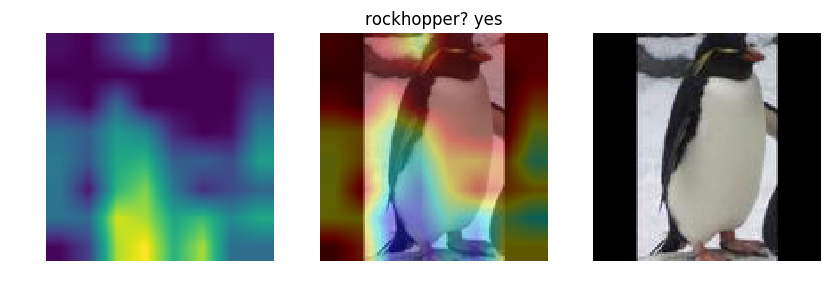

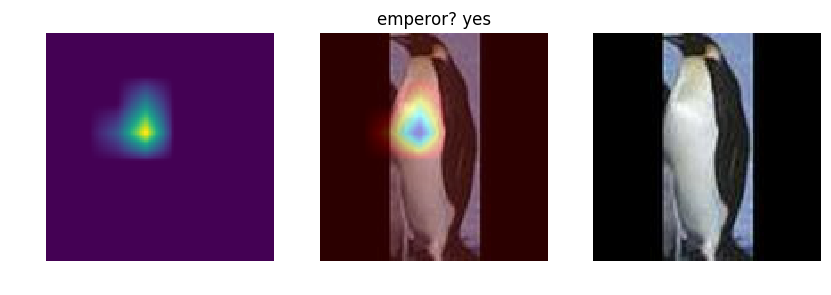

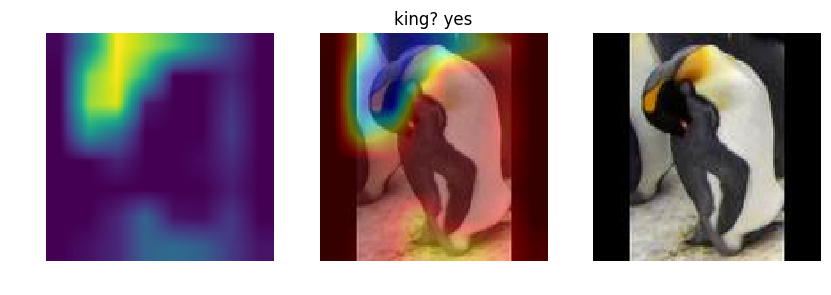

In [18]:
for i in range(10):
    visualize_cam(ib_model, output_tester.correct_no_list[i], 'block5_conv1', output_tester)
plt.show()

## VGG16 imagenet based fine tuning using Augmentation

In [19]:
ib_model, conv_base = imagenet_based_network(input_shape, num_classes)
print(len(ib_model.trainable_weights))

for layer in conv_base.layers:
    layer.trainable = False

print(len(ib_model.trainable_weights))

30
4


In [20]:
ib_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [21]:
# with augmentation dataset
ds = PenguinsDataset(train_dir, batch_size, input_shape[:2], validation_split)
ds.create_generator({'rotation_range':40, 
                     'width_shift_range':0.2, 
                     'height_shift_range':0.2, 
                     'shear_range':0.2, 
                     'zoom_range':0.2, 
                     'horizontal_flip':True, 
                     'fill_mode':'nearest'})

trainer = Trainer(ib_model, loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=2e-5), 
                  log_dir="imagenet_aug", model_file_name="imagenet_aug.h5")
trainer.train(ds, batch_size=batch_size, epochs=30)


Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Epoch 1/30
240/240 [==============================] - 8s 33ms/step - loss: 1.7016 - acc: 0.2833 - val_loss: 1.6118 - val_acc: 0.3167

Epoch 00001: val_loss improved from inf to 1.61181, saving model to imagenet_aug/imagenet_aug.h5
Epoch 2/30
240/240 [==============================] - 8s 32ms/step - loss: 1.5336 - acc: 0.3908 - val_loss: 1.4359 - val_acc: 0.4483

Epoch 00002: val_loss improved from 1.61181 to 1.43591, saving model to imagenet_aug/imagenet_aug.h5
Epoch 3/30
240/240 [==============================] - 8s 32ms/step - loss: 1.4269 - acc: 0.4567 - val_loss: 1.3314 - val_acc: 0.5050

Epoch 00003: val_loss improved from 1.43591 to 1.33144, saving model to imagenet_aug/imagenet_aug.h5
Epoch 4/30
240/240 [==============================] - 8s 32ms/step - loss: 1.3471 - acc: 0.4846 - val_loss: 1.3215 - val_acc: 0.4883

Epoch 00004: val_loss improved from 1.33144 to 1.32146, saving model to imagenet_a

In [22]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(len(ib_model.trainable_weights))

10


In [23]:
model_path = os.path.join(trainer.log_dir, trainer.model_file_name)
callbacks = [
    TensorBoard(log_dir=trainer.log_dir),
    ModelCheckpoint(model_path, 
        monitor='val_loss', verbose=1, save_best_only=True),
]
ib_model.compile(loss="categorical_crossentropy", 
                 optimizer=optimizers.RMSprop(lr=1e-5), 
                 metrics=["acc"])
history = ib_model.fit_generator(ds.train_gen, 
    steps_per_epoch=ds.train_steps_per_epoch(),
    epochs=100,
    validation_data=ds.valid_gen,
    validation_steps=ds.validation_steps_per_epoch(),
    callbacks=callbacks,
    verbose=trainer.verbose)


Epoch 1/100
240/240 [==============================] - 8s 35ms/step - loss: 0.8537 - acc: 0.6800 - val_loss: 0.7779 - val_acc: 0.7233

Epoch 00001: val_loss improved from inf to 0.77794, saving model to imagenet_aug/imagenet_aug.h5
Epoch 2/100
240/240 [==============================] - 8s 33ms/step - loss: 0.7596 - acc: 0.7212 - val_loss: 0.7076 - val_acc: 0.7567

Epoch 00002: val_loss improved from 0.77794 to 0.70762, saving model to imagenet_aug/imagenet_aug.h5
Epoch 3/100
240/240 [==============================] - 8s 33ms/step - loss: 0.7128 - acc: 0.7338 - val_loss: 0.7445 - val_acc: 0.7400

Epoch 00003: val_loss did not improve from 0.70762
Epoch 4/100
240/240 [==============================] - 8s 33ms/step - loss: 0.6638 - acc: 0.7571 - val_loss: 0.6878 - val_acc: 0.7583

Epoch 00004: val_loss improved from 0.70762 to 0.68784, saving model to imagenet_aug/imagenet_aug.h5
Epoch 5/100
240/240 [==============================] - 8s 32ms/step - loss: 0.6272 - acc: 0.7704 - val_loss: 0

240/240 [==============================] - 8s 33ms/step - loss: 0.1740 - acc: 0.9417 - val_loss: 0.4961 - val_acc: 0.8633

Epoch 00041: val_loss did not improve from 0.45862
Epoch 42/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1547 - acc: 0.9512 - val_loss: 0.4998 - val_acc: 0.8767

Epoch 00042: val_loss did not improve from 0.45862
Epoch 43/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1434 - acc: 0.9429 - val_loss: 0.6032 - val_acc: 0.8550

Epoch 00043: val_loss did not improve from 0.45862
Epoch 44/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1512 - acc: 0.9492 - val_loss: 0.5339 - val_acc: 0.8700

Epoch 00044: val_loss did not improve from 0.45862
Epoch 45/100
240/240 [==============================] - 8s 33ms/step - loss: 0.1706 - acc: 0.9396 - val_loss: 0.4848 - val_acc: 0.8800

Epoch 00045: val_loss did not improve from 0.45862
Epoch 46/100
240/240 [==============================] - 8s 33ms/step - loss: 0

240/240 [==============================] - 8s 33ms/step - loss: 0.1098 - acc: 0.9592 - val_loss: 0.6204 - val_acc: 0.8667

Epoch 00085: val_loss did not improve from 0.45862
Epoch 86/100
240/240 [==============================] - 8s 33ms/step - loss: 0.0812 - acc: 0.9750 - val_loss: 0.6039 - val_acc: 0.8817

Epoch 00086: val_loss did not improve from 0.45862
Epoch 87/100
240/240 [==============================] - 8s 33ms/step - loss: 0.0899 - acc: 0.9700 - val_loss: 0.5443 - val_acc: 0.8817

Epoch 00087: val_loss did not improve from 0.45862
Epoch 88/100
240/240 [==============================] - 8s 33ms/step - loss: 0.0945 - acc: 0.9679 - val_loss: 0.6151 - val_acc: 0.8717

Epoch 00088: val_loss did not improve from 0.45862
Epoch 89/100
240/240 [==============================] - 8s 33ms/step - loss: 0.0799 - acc: 0.9762 - val_loss: 0.5951 - val_acc: 0.8750

Epoch 00089: val_loss did not improve from 0.45862
Epoch 90/100
240/240 [==============================] - 8s 33ms/step - loss: 0

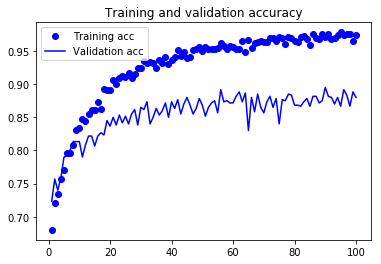

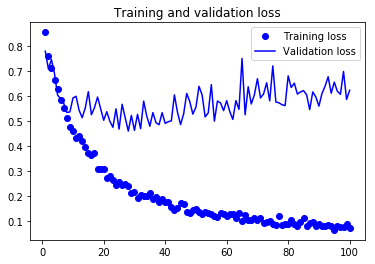

In [24]:
show_graph(history)

In [25]:
tester = Tester(os.path.join(base_dir, 'test'), input_shape[:2] )
tester.predict(ib_model)

score = ib_model.evaluate(tester.x_test, tester.y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 360 images belonging to 6 classes.
Test loss: 0.6524095416069031
Test accuracy: 0.8694444444444445


4層モデルデータ拡張ありとほぼ同じ。

In [26]:
output_tester = Tester(os.path.join(base_dir, 'for_output'), input_shape[:2] )
output_tester.predict(ib_model)
print(output_tester.correct_no_list)
print(output_tester.in_correct_no_list)

Found 42 images belonging to 6 classes.
[2, 3, 4, 10, 13, 14, 16, 17, 19, 20, 21, 25, 27, 28, 29, 30, 31, 33, 36, 37, 38, 39, 40]
[0, 1, 5, 6, 7, 8, 9, 11, 12, 15, 18, 22, 23, 24, 26, 32, 34, 35, 41]


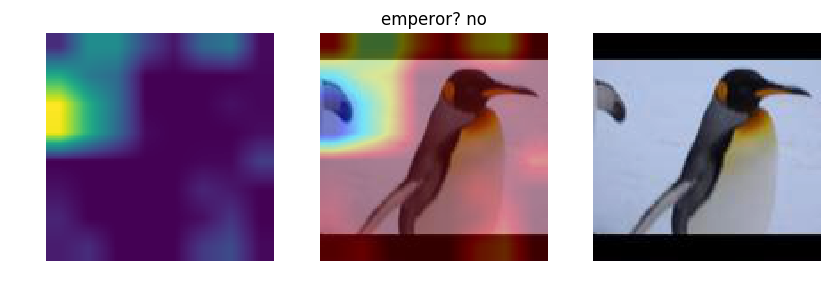

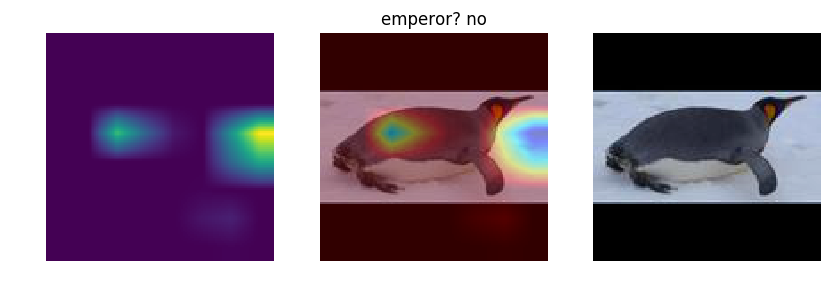

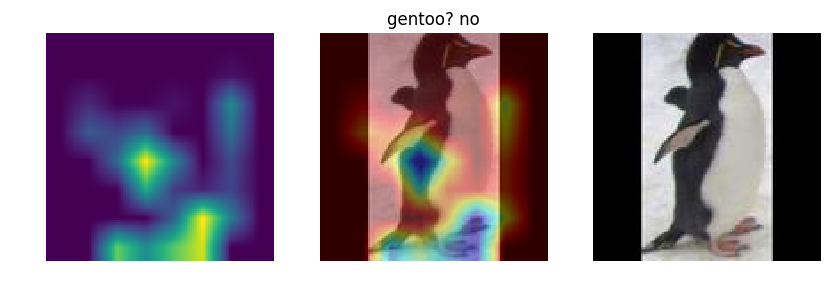

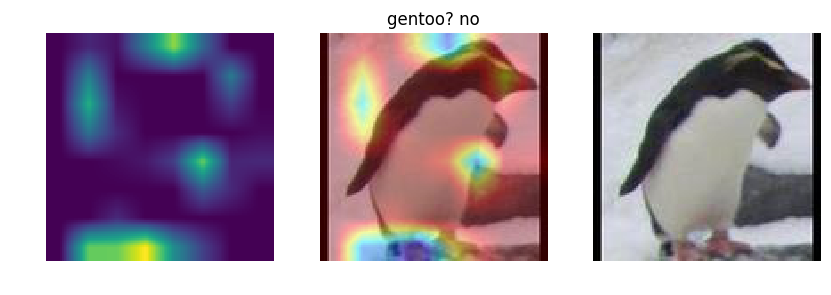

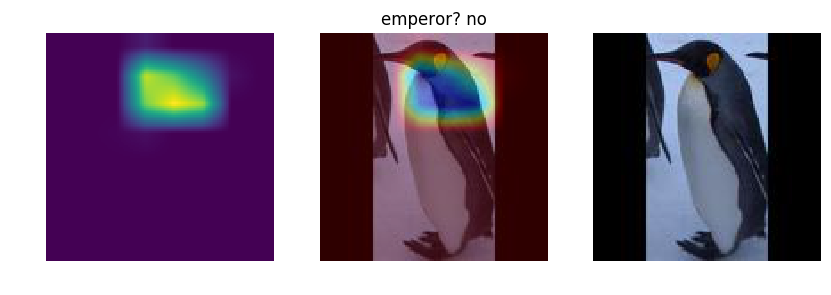

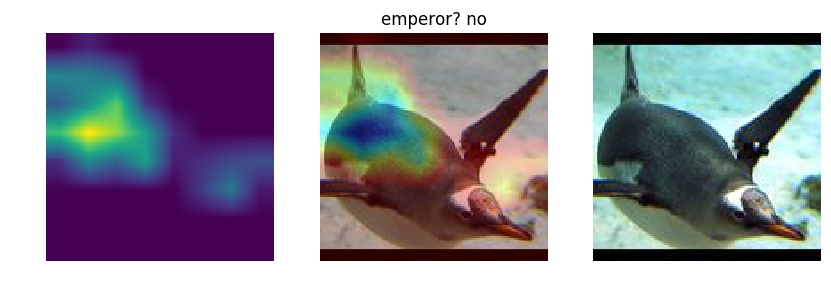

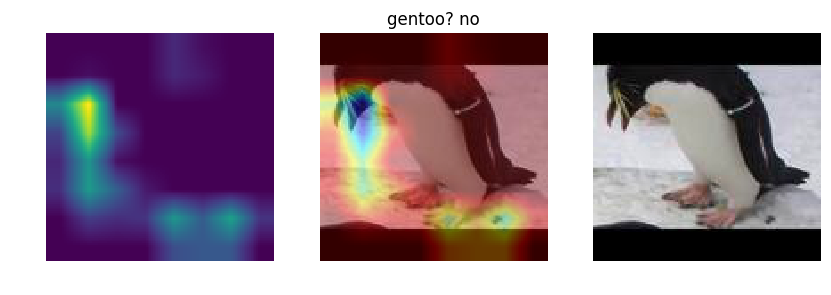

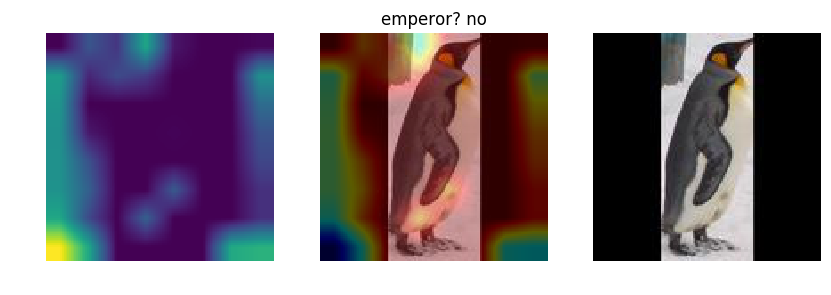

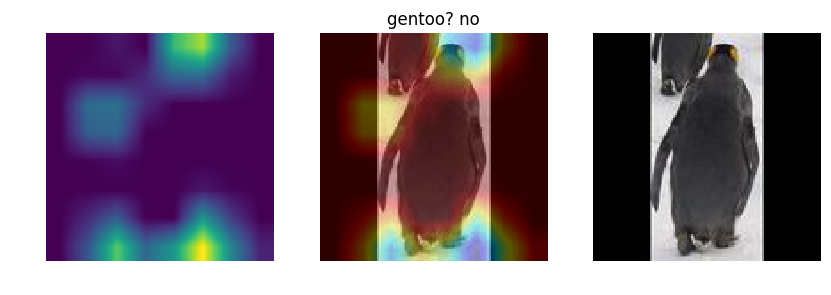

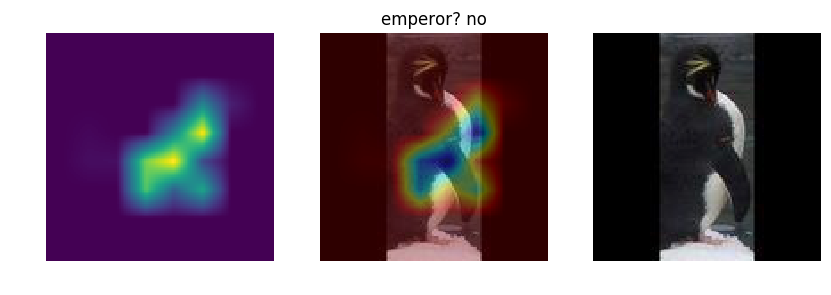

In [27]:
# 5番目の畳込みブロック
for i in range(10):
    visualize_cam(ib_model, output_tester.in_correct_no_list[i], 'block5_conv1', output_tester)
plt.show()

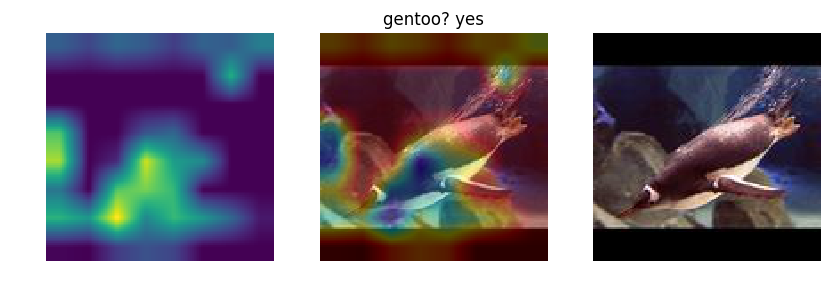

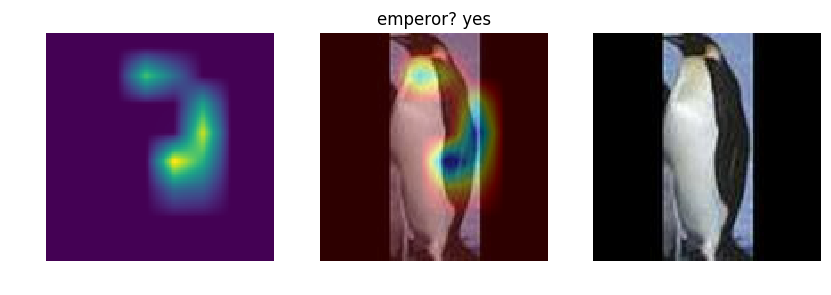

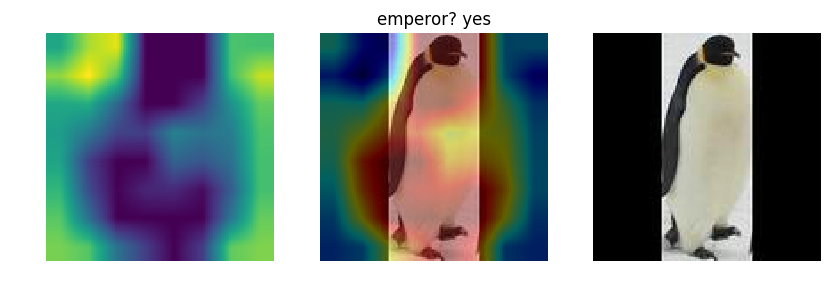

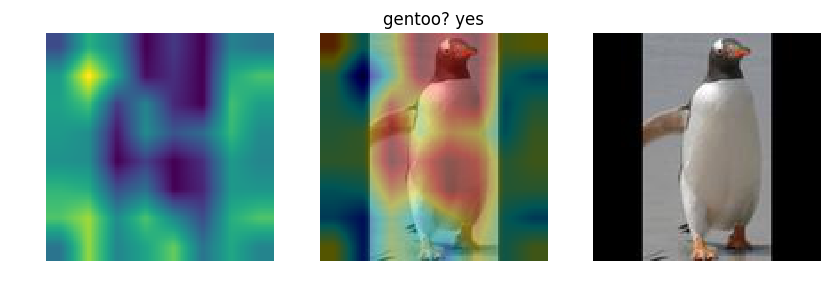

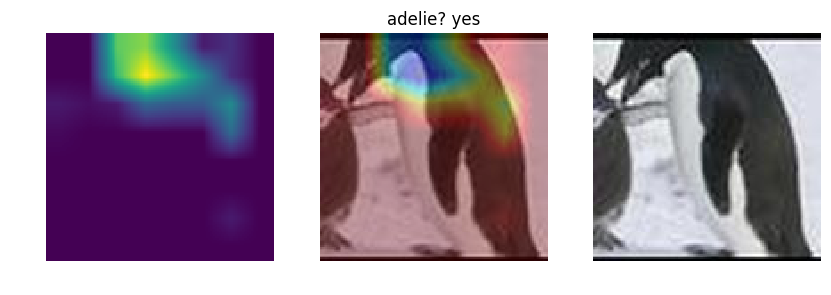

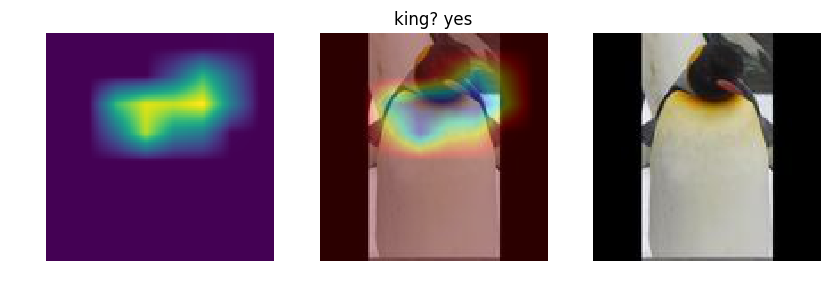

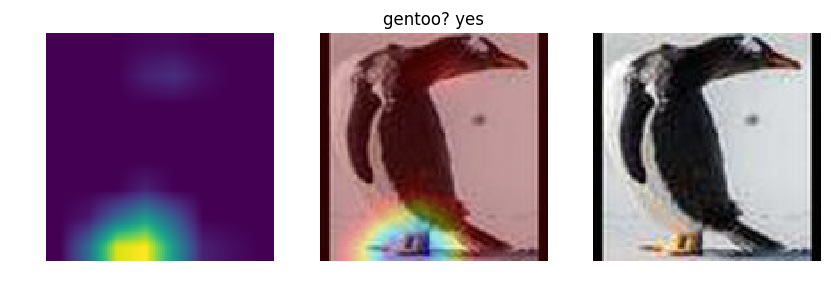

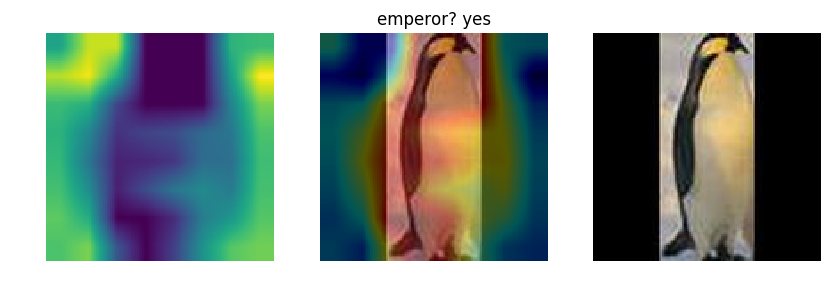

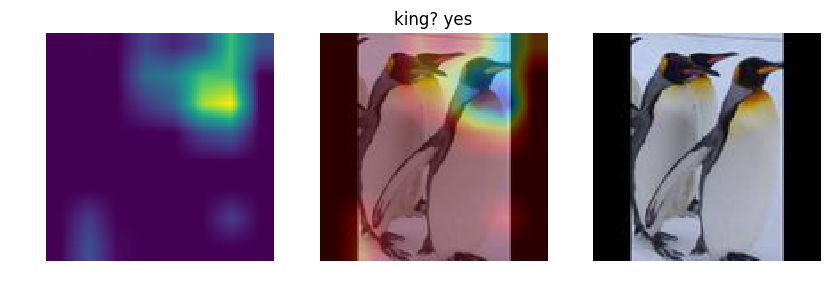

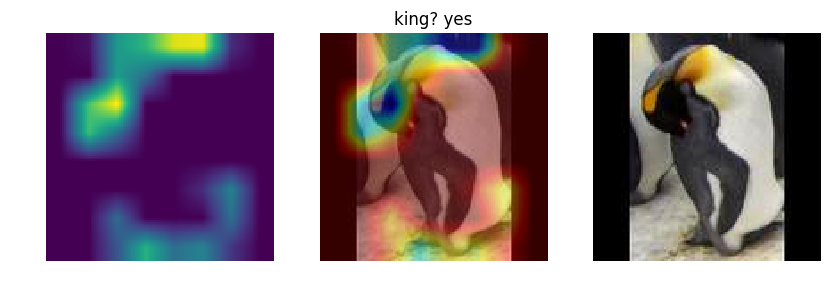

In [28]:
for i in range(10):
    visualize_cam(ib_model, output_tester.correct_no_list[i], 'block5_conv1', output_tester)
plt.show()

ううむ、この結果はどこか間違っているように思います。